In [13]:
# dataset = 'cifar10', model = mobile, CELoss vs middles

from Dataloaders import dataloader_cifar10, dataloader_image_20, dataloader_ccpd

from Models import mobilenetv2, resnet

models_name = {'mobilenetv2':mobilenetv2, 'resnet':resnet}
datasets_name = {'cifar10':dataloader_cifar10, 'image_20':dataloader_image_20, 'ccpd':dataloader_ccpd}
middle_size = {x:2**x for x in range(5)}
gate_size = {x:2**x for x in range(5)}

quantization = False
int_trans = False


Files already downloaded and verified
Files already downloaded and verified


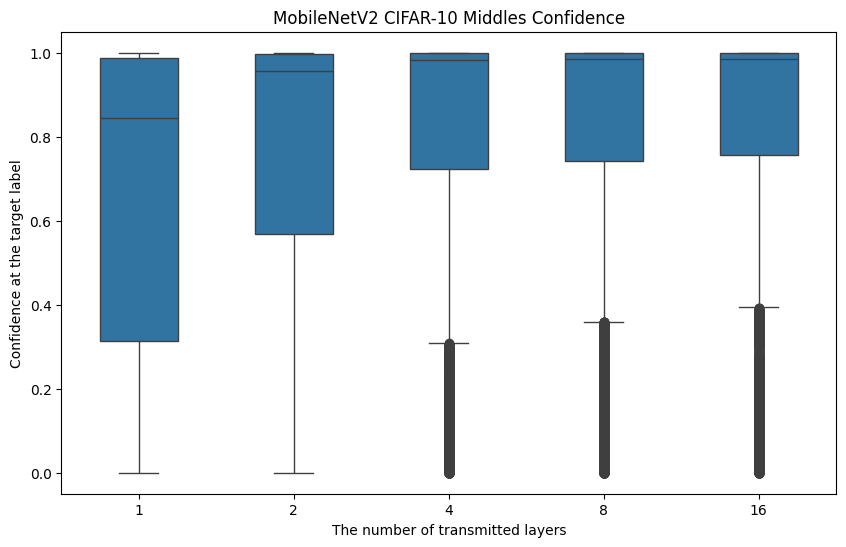

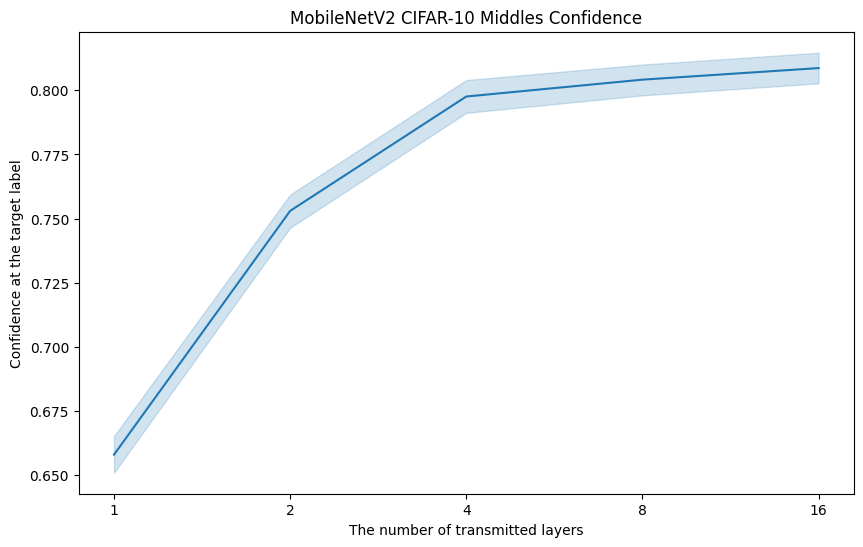

In [29]:
# dataset = 'cifar10', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), 10000))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size]
middles_conf['label'] = test.dataset.targets
middles_conf['label'] = middles_conf['label'].apply(lambda x: test.dataset.classes[x])
middles_conf = middles_conf.melt(id_vars='label', var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [ ]:
# dataset = 'cifar10', model = resnet, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), 10000))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size]
middles_conf['label'] = test.dataset.targets
middles_conf['label'] = middles_conf['label'].apply(lambda x: test.dataset.classes[x])
middles_conf = middles_conf.melt(id_vars='label', var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size.values()])
plt.ylabel('Confidence at the target label')
plt.show()